In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import os
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from lavse.data.loaders import get_loader
from lavse.data.collate_fns import Collate
from lavse.train.evaluation import predict_loader


from run import load_yaml_opts, parse_loader_name
from lavse.model import model
from lavse.utils import helper
import torch

import json 
from glob import glob
from matplotlib import pyplot as plt
# import numpy as np
# from model import l2norm
# from evaluation import encode_data_vector

In [3]:
collate = Collate()

In [4]:
data_path = '/opt/jonatas/datasets/lavse/'
data_name = 'coco_precomp'

In [5]:
loader = get_loader(
        data_split='test',
        data_path=data_path,
        data_name=data_name,
        loader_name='precomp',
        local_rank=0,
        lang='en',
        text_repr='word',
        vocab_paths=['../.vocab_cache/coco_precomp.json'],
        ngpu=0,
        batch_size=128,
#         **opt.dataset.val,
    )

Image div 1


In [6]:
dataset = loader.dataset

In [7]:
from pathlib import Path
import pickle 
import numpy as np
ids = np.loadtxt(Path(data_path)/ 'coco_precomp' / 'test_ids.txt', dtype=int)

In [8]:
dataset.ids = ids

In [9]:
instance = dataset[0]
instance = collate([instance])

In [10]:
data = None
with open('/opt/jonatas/datasets/lavse/coco/annotations/captions_val2014.json') as fp:
    data = json.load(fp)

In [11]:
features = glob('/opt/jonatas/datasets/vqa/coco/extract_rcnn/2018-04-27_bottom-up-attention_fixed_36/*')
features = {fname.split('/')[-1][:-3]: fname for fname in features}

In [12]:
data_dict = {x['id']: x for x in data['images']}

In [13]:
for f in features:
    print(f)
    break

COCO_val2014_000000237628.jpg.


In [14]:
_id = dataset.ids[0]
instance_info = data_dict[_id]
img_path = instance_info['file_name']
print(img_path)
feat = features[f'{img_path}.']
print(feat)

COCO_val2014_000000391895.jpg
/opt/jonatas/datasets/vqa/coco/extract_rcnn/2018-04-27_bottom-up-attention_fixed_36/COCO_val2014_000000391895.jpg.pth


In [15]:
f = torch.load(feat)

In [16]:
f.keys()

dict_keys(['cls_scores', 'rois', 'pooled_feat', 'cls', 'norm_rois'])

In [17]:
bboxes = f['rois'].data.numpy().astype(np.int)

In [18]:
im = plt.imread(Path(data_path) / 'coco' / 'images' / 'val2014' / instance_info['file_name'])

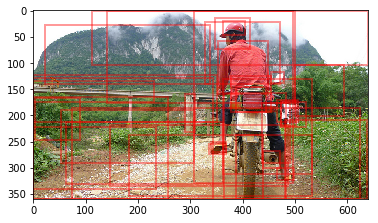

In [19]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
ax.imshow(im)

for bbox in bboxes:    
    # [bbox_x, bbox_y, bbox_w, bbox_h] = b
    # [bbox_x, bbox_w, bbox_y, bbox_h] = b
#     [bbox_x, bbox_y, bbox_w, bbox_h] = b
#     poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
#     np_poly = np.array(poly).reshape((4,2))

#     p = PatchCollection([Polygon(np_poly)], facecolor=['black'], linewidths=0, alpha=0.4)
#     ax.add_collection(p)

    # Create a Rectangle patch    
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.4)
            )

# Add the patch to the Axes
# ax.add_patch(rect)

In [20]:
path = Path('/opt/jonatas/repos/lavse/logs_aaai2/coco_precomp/adapt_t2i/simple-glove_1024-nofreeze-lr7/')
opt = load_yaml_opts(path / 'options.yaml')
model_path = path / 'best_model.pkl'


opt['model']['txt_enc']['params']['glove_path'] = '/opt/jonatas/repos/lavse/.vocab_cache/glove_coco_precomp.json.pkl'

In [21]:
print(opt.dataset.lang)
opt.dataset.vocab_paths = ['../{}'.format(p) for p in opt.dataset.vocab_paths]
for data_name in opt.dataset.val.data:
    data_name, lang = parse_loader_name(data_name)
    print(data_name)
    loader = get_loader(
        data_split='test',
        data_path=data_path,
        data_name=data_name,
        loader_name=opt.dataset.loader_name,
        local_rank=0,
        lang=lang,
        text_repr=opt.dataset.text_repr,
        vocab_paths=['/opt/jonatas/repos/lavse/.vocab_cache/coco_precomp.json'],
        ngpu=1,
        **opt.dataset.val,
    )

device = torch.device('cuda:0')

loader
tokenizers = loader.dataset.tokenizers
if type(tokenizers) != list:
    tokenizers = [tokenizers]

{}
coco_precomp
Image div 1


In [22]:
# load model and options
model = model.LAVSE(**opt.model, tokenizers=tokenizers)#.to(device)
checkpoint = helper.restore_checkpoint(
    path=model_path,
    model=model,
)

model.set_devices_(
    txt_devices=[device],
    img_devices=[device],
    loss_device=device,
)
is_master = True
model.master = is_master # FIXME: Replace "if print" by built_in print


In [23]:
img_embs, cap_embs, cap_lens = predict_loader(model, loader, device)
print(img_embs.shape, cap_embs.shape)

(1000, 36, 1024) (5000, 77, 1024)


In [24]:
sim = model.similarity.similarity(
    torch.FloatTensor(img_embs[:10]).cuda(),
    torch.FloatTensor(cap_embs[:10*5]).cuda(),
    cap_lens,
)

In [104]:
all_weights = model.similarity.similarity.masks[0]

In [150]:
weights = all_weights[1]
print(weights.shape)
weights = weights.sum(0)
print(weights.shape)

torch.Size([1024, 36])
torch.Size([36])


In [151]:
weights

tensor([-34.2643, -19.0483, -64.8175,  32.0145,  -7.1168, -43.9512,  32.4623,
          3.7935, -94.1561, -32.8566,  12.8104,  15.4832,  97.2693, -69.8357,
         20.8813, -31.5934,  19.1684, -21.5209,  47.9678, -18.8005, -14.3692,
        142.5391,  10.6442, -41.8123,  68.0623, 141.7010,   1.3760,  13.8050,
        -18.9637,  54.5248,  31.9449,  -2.2946,  92.8566,  28.5362, -23.0953,
         35.5004], device='cuda:0', grad_fn=<SumBackward2>)

In [161]:
import torch.nn as nn
# weights = nn.Softmax(-1)(weights)
weights = weights / weights.max()
w = nn.ReLU()(weights)
# w = (weights - weights.min()) / (weights.max() - weights.min())
# w = nn.Softmax(-1)(w)
w

tensor([0.0000, 0.0000, 0.0000, 0.2246, 0.0000, 0.0000, 0.2277, 0.0266, 0.0000,
        0.0000, 0.0899, 0.1086, 0.6824, 0.0000, 0.1465, 0.0000, 0.1345, 0.0000,
        0.3365, 0.0000, 0.0000, 1.0000, 0.0747, 0.0000, 0.4775, 0.9941, 0.0097,
        0.0969, 0.0000, 0.3825, 0.2241, 0.0000, 0.6514, 0.2002, 0.0000, 0.2491],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [162]:
torch.save(all_weights, 'weights.pkl')

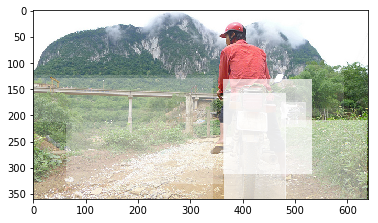

In [163]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
ax.imshow(im)
# w = weights / weights.max()
for bbox, _w in zip(bboxes, w):
    # [bbox_x, bbox_y, bbox_w, bbox_h] = b
    # [bbox_x, bbox_w, bbox_y, bbox_h] = b
#     [bbox_x, bbox_y, bbox_w, bbox_h] = b
#     poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
#     np_poly = np.array(poly).reshape((4,2))

#     p = PatchCollection([Polygon(np_poly)], facecolor=['black'], linewidths=0, alpha=0.4)
#     ax.add_collection(p)

    # Create a Rectangle patch    
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=True,
                      color='white',
                      edgecolor='gray', linewidth=0, alpha=_w*0.70,)
            )

# Add the patch to the Axes
# ax.add_patch(rect)

In [141]:
dataset.captions[1]

'Man riding a motor bike on a dirt road on the countryside .'